# (STA 380) Introduction to Machine Learning, Part 2: Exercises
Names: Neal Makwana, Quinlan O'Connell, Ashley Hattendorf, and Maru Lasala

# Question 9: Image classification with neural networks

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [ ]:

dataset = datasets.ImageFolder('EuroSAT_RGB', transform=transforms.ToTensor())

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class ImageClassifierNN(nn.Module):
    def __init__(self, num_classes):
        super(ImageClassifierNN, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, num_classes)  # Final output layer

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(-1, 128 * 8 * 8)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

num_classes = len(dataset.classes)
model = ImageClassifierNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
print(num_classes)
print(dataset.classes)

10
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [ ]:
# Training the model
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


Epoch 1/10, Loss: 1.2610
Epoch 2/10, Loss: 0.7998
Epoch 3/10, Loss: 0.6745
Epoch 4/10, Loss: 0.5708
Epoch 5/10, Loss: 0.5041
Epoch 6/10, Loss: 0.4541
Epoch 7/10, Loss: 0.4043
Epoch 8/10, Loss: 0.3523
Epoch 9/10, Loss: 0.3008
Epoch 10/10, Loss: 0.2615


In [ ]:
# Evaluating the model on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Calculate overall accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Overall Test Accuracy: {accuracy*100:.2f}%')


Overall Test Accuracy: 86.24%


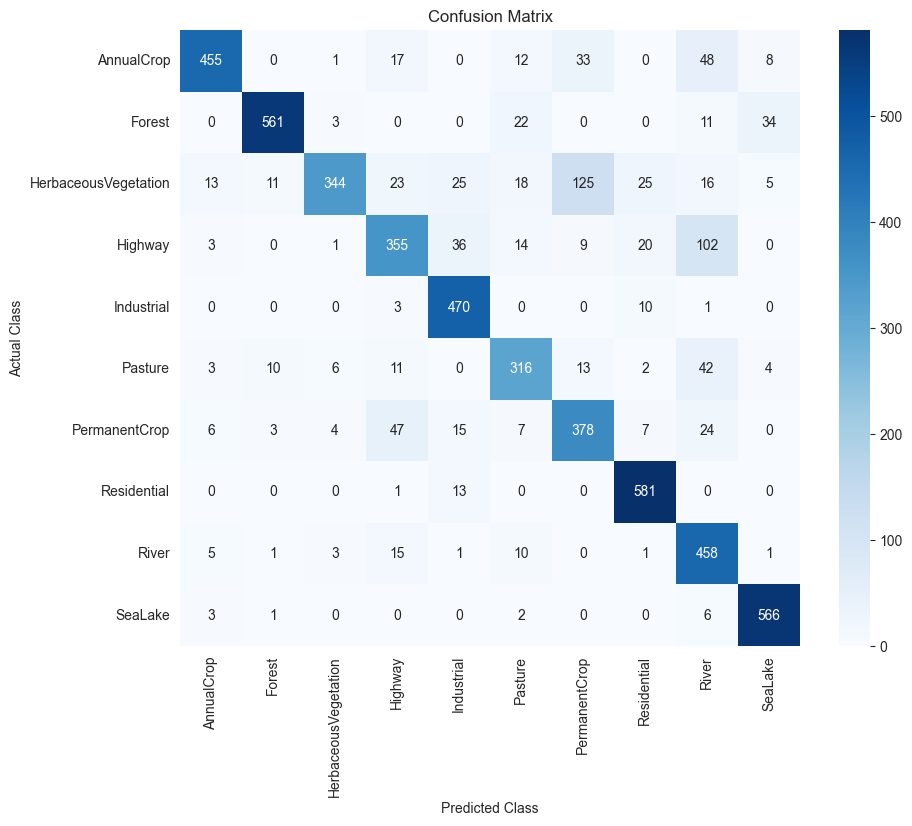

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()


ValueError: num must be an integer with 1 <= num <= 16, not 17

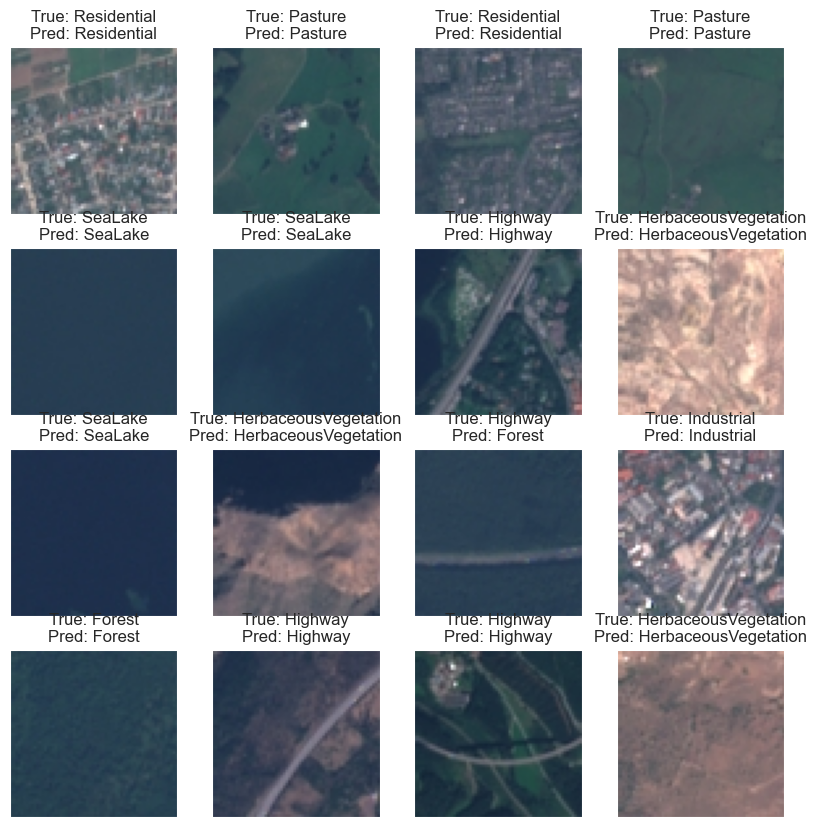

In [ ]:
import matplotlib.pyplot as plt


def show_images(images, labels, preds, classes):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        img = images[i].permute(1, 2, 0)
        plt.imshow(img)
        ax.set_title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
    plt.show()

# Get a batch of test images
model.eval()
images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Show the images with true and predicted labels
show_images(images, labels, preds, dataset.classes)
